# Classification of Handwritten Digits from the MNIST Database

## Gaussian Discriminant Analysis

We assume each class of digit is distributed according to some Multivariate Gaussian whose mean and covariance we calculate (using the sample mean and sample covariance of each digit).

To classify a digit then, we choose the class such that the probability that the digit belongs to the class is maximum. We calculate this probability using Baye's Theorem ( $P(y | x) = \frac{P(x | y)P(y)}{P(x)}$ ). This is an example of a generative learning model.

However, while calculating the sample covariance, it will come out to be singular or almost singular, as there are a large number of principal components with eigenvalues close to 0 (or 0). Therefore, we must reduce the dimensionality of the data by projecting it onto the space spanned by the first few principal components.

In [126]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

NUM_PRINC = 150 # Number of Principal Components (our hyperparameter)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train_r = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])


means = np.zeros((10, x_train_r.shape[1]))
counts = np.zeros(10)
covariances = np.zeros((10, x_train_r.shape[1], x_train_r.shape[1]))

for i in range(x_train_r.shape[0]):
    means[y_train[i]] = np.add(means[y_train[i]], x_train_r[i])
    counts[y_train[i]] += 1

for i in range(10):
    means[i] = means[i]/counts[i]

for i in range(x_train_r.shape[0]):
    v = np.subtract(x_train_r[i], means[y_train[i]]).reshape((x_train_r.shape[1], 1))
    v = np.matmul(v, np.transpose(v))
    covariances[y_train[i]] = np.add(covariances[y_train[i]], v)

princ_comps = np.zeros((10, NUM_PRINC, x_train_r.shape[1]))
eigen_vals = np.zeros((10, NUM_PRINC))


for i in range(10):
    covariances[i] = covariances[i]/counts[i]
    x, y = np.linalg.eigh(covariances[i])
    eigen_vals[i] = x[x.size - NUM_PRINC:][::-1]
    for j in range(NUM_PRINC):
        princ_comps[i][j] = y[: , y.shape[1] - j - 1]

def projection(num, vector):
    return np.array([np.dot(x, vector) for x in princ_comps[num]])

log_determinants = np.zeros(10)
proj_means = np.zeros((10, NUM_PRINC))

for i in range(10):
    log_determinants[i] = np.sum(np.log(eigen_vals[i]))
    proj_means[i] = projection(i, means[i])

def neg_log_prob(num, vector):
    wrt_mean = np.subtract(projection(num, vector), proj_means[num])
    return log_determinants[num] + np.sum([(wrt_mean[i] ** 2)/eigen_vals[num][i] for i in range(NUM_PRINC)]) + np.log(x_train_r.shape[0]/counts[num])

def prediction(digit):
    digit = digit.reshape(x_train_r.shape[1])
    return np.argmin(np.array([neg_log_prob(i, digit) for i in range(10)]))

num_occ = 0
for i in range(x_test.shape[0]):
    if prediction(x_test[i]) == y_test[i]:
        num_occ += 1

print(f'Accuracy: {num_occ*100/x_test.shape[0]}%')

Accuracy: 95.59%


Predicted: 8
Actual: 8


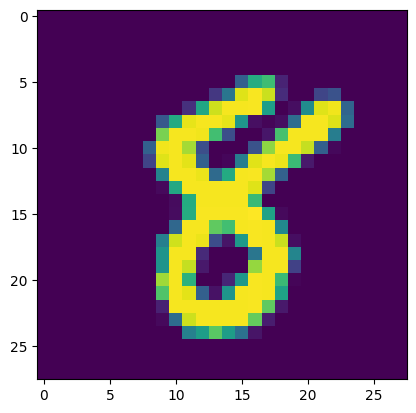

In [128]:
i = np.random.randint(0, x_test.shape[0])
plt.imshow(x_test[i])
print(f'Predicted: {prediction(x_test[i])}')
print(f'Actual: {y_test[i]}')

### Hyperparameter Tuning
The hyperparameter here is the number of principal components considered. We choose the number that maximizes the accuracy on testing.
| Number of Principal Components     | Accuracy         |
| ---------------------------------- | -----------------|
| 1                                  | 4.95%            |
| 80                                 | 94.24%           |
| 150                                | 95.59% (highest) |
| 240                                | 94.78%           |
| 320                                | 93.72%           |
| 400                                | 91.45%           |
| 480                                | 87.61%           |
| 560                                | 65.83%           |
| 640                                | 9.8%             |
| 720                                | 9.8%             |
| 784                                | 9.8%             |


# Using Classwise Logistic Regression

Here we perform logistic regression on each class of digit. For a given digit, then we choose the class with maximum (log) likelihood that the digit belongs to that class. We use stochastic gradient descent to get the values of the regression parameters. 

Note here that these likelihoods are not probabilities that the digit belongs to a particular class (they need not even sum to 1). This is a discriminative algorithm.

The naive implementation of this algorithm is unlikely to give a very good result, as for each class the ratio of members of the class to non-members of the class is 1 : 9 (ie, the data is biased). Therefore, we correct for the bias in the data by taking a 1 : 1 ratio of class members and non-class members during gradient descent. Even after this correction, classwise logistic regression will be inferior to softmax algorithm as this is fundamentally a multiclass problem.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_r = np.zeros((x_train.shape[0], 1 + x_train.shape[1]*x_train.shape[2]))

for i in range(x_train_r.shape[0]):
    x_train_r[i] = np.insert(np.reshape(x_train[i], (x_train.shape[1]*x_train.shape[2], )), 0, 1)

params = np.zeros((10, x_train_r.shape[1]))

def hypothesis(digit, vector):
    return 1/(1 + np.exp(-np.dot(params[digit], vector)))

# Correct for bias in data
num_to_list = {}
for i in range(10):
    num_to_list[i] = []

for i in range(x_train_r.shape[0]):
    num_to_list[y_train[i]].append(i)

for i in range(10):
    num_to_list[i] = np.array(num_to_list[i])

# Our hyperparameters
NUM_ITER = 6000
LEARN_RATE = 1e-2
BATCH_SIZE = 360

def grad_descent(digit, iterations = NUM_ITER, learning_rate = LEARN_RATE):
    for _ in range(iterations):
        sum = np.zeros(x_train_r.shape[1])
        batch = np.concatenate(tuple([np.random.choice(num_to_list[p], int(BATCH_SIZE/2)) if p == digit else np.random.choice(num_to_list[p], int(BATCH_SIZE/18)) for p in range(10)]))

        for i in batch:
            if y_train[i] == digit:
                sum += (1 - hypothesis(digit, x_train_r[i]))*x_train_r[i]
            else:
                sum -= hypothesis(digit, x_train_r[i])*x_train_r[i]
        params[digit] += learning_rate*sum


for i in range(10):
    grad_descent(i)

def prediction(digit):
    r_dig = np.insert(np.reshape(digit, (x_train.shape[1]*x_train.shape[2], )), 0, 1)
    return np.argmax([hypothesis(i, r_dig) for i in range(10)])

num_occ = 0
for i in range(x_test.shape[0]):
    if prediction(x_test[i]) == y_test[i]:
        num_occ += 1

print(f'Accuracy: {num_occ*100/x_test.shape[0]}%')

/tmp/ipykernel_7009/3849353442.py:15: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-np.dot(params[digit], vector)))


Accuracy: 84.69%


Predicted: 4
Actual: 4


/tmp/ipykernel_7009/3849353442.py:15: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-np.dot(params[digit], vector)))


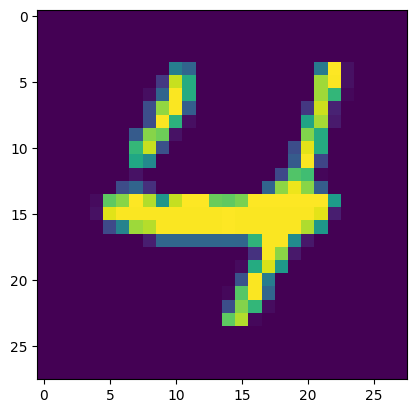

In [7]:
i = np.random.randint(0, x_test.shape[0])
plt.imshow(x_test[i])
print(f'Predicted: {prediction(x_test[i])}')
print(f'Actual: {y_test[i]}')

With 6000 iterations of gradient descent, a learning rate of 0.01 and a minibatch size of 180, we get an accuracy of 84.69%.

## Using Softmax Regression

This is more appropriate for multiclass classification than plain logistic regression. Here the probabilities of a digit belonging to a class are drawn from a multinomial distribution, on which we perform maximum likelihood estimation via stochastic gradient descent. 

This is also a discriminative model.

In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_r = np.zeros((x_train.shape[0], 1 + x_train.shape[1]*x_train.shape[2]))

for i in range(x_train_r.shape[0]):
    x_train_r[i] = np.insert(np.reshape(x_train[i], (x_train.shape[1]*x_train.shape[2], )), 0, 1)

params = np.zeros((x_train_r.shape[1], 9))

def sstat(digit):
    arr = np.zeros(9)
    if digit < 9:
        arr[digit] = 1
    return arr

def hypothesis(vector):
    arr = np.matmul(np.transpose(params), vector)
    narr = np.zeros(9)
    for i in range(9):
        sum = np.exp(-arr[i])
        for j in range(9):
            sum += np.exp(arr[j] - arr[i])
        narr[i] = 1/sum
    return narr

# Our hyperparameters for gradient descent
NUM_ITER = 10000
LEARN_RATE = 1e-2
BATCH_SIZE = x_train.shape[0]

for _ in range(NUM_ITER):
    sum = np.zeros((x_train_r.shape[1], 9))
    batch = np.random.choice(range(x_train_r.shape[0]), BATCH_SIZE)
    for i in batch:
        sum += np.outer(x_train_r[i], sstat(y_train[i]) - hypothesis(x_train_r[i]))
    params += LEARN_RATE*sum

def prediction(img):
    dig = np.insert(img.reshape(x_train.shape[1]*x_train.shape[2]), 0, 1)
    hyp = hypothesis(dig)
    hyp = np.append(hyp, 1 - np.sum(hyp))
    return np.argmax(hyp)

num_occ = 0
for i in range(x_test.shape[0]):
    if prediction(x_test[i]) == y_test[i]:
        num_occ += 1

print(f'Accuracy: {num_occ*100/x_test.shape[0]}%')

/tmp/ipykernel_7009/1786535468.py:23: RuntimeWarning: overflow encountered in exp
  sum = np.exp(-arr[i])
/tmp/ipykernel_7009/1786535468.py:25: RuntimeWarning: overflow encountered in exp
  sum += np.exp(arr[j] - arr[i])


Predicted: 7
Actual: 7


/tmp/ipykernel_7009/3308815789.py:23: RuntimeWarning: overflow encountered in exp
  sum = np.exp(-arr[i])
/tmp/ipykernel_7009/3308815789.py:25: RuntimeWarning: overflow encountered in exp
  sum += np.exp(arr[j] - arr[i])


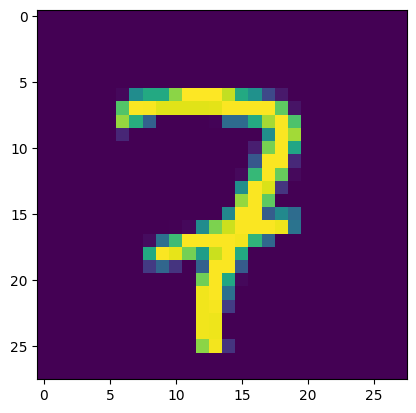

In [31]:
i = np.random.randint(0, x_test.shape[0])
plt.imshow(x_test[i])
print(f'Predicted: {prediction(x_test[i])}')
print(f'Actual: {y_test[i]}')

With 8000 iterations of gradient descent, a learning rate of 0.01 and a minibatch size of 500, we get an accuracy of 90.93%.